In [ ]:
import pyemoji

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, SimpleRNN
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
import emoji
import string
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
%matplotlib inline
from sklearn.model_selection import train_test_split

In [ ]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
stop_words=pd.read_excel('stop_words.xlsx')
stop_words = list(stop_words['words'])

In [ ]:
def dig(x):
  if x=='positive':
    dig_pos=1
    dig_neg=0
  elif x=='negative':
    dig_pos=0
    dig_neg=1
  else:
    dig_pos=0
    dig_neg=0
  return dig_pos,dig_neg

In [ ]:
def sep_smiles(x):
    x=str(x)
    smile = re.findall(r'\){1,}', x)
    sad = re.findall(r'\({1,}', x)
    for word in smile:
        new_word=' '+'🙂'+' '
        x=x.replace(word, new_word)
    for word in sad:
        new_word=' '+'😞'+' '
        x=x.replace(word, new_word)
    emojis = emoji.distinct_emoji_list(x)
    for word in emojis:
        #new_word=' s'+str(word.encode('unicode_escape'))[4:-1]+' '
        new_word=' '+word+' '
        x=x.replace(word, new_word)
    return(x)

In [ ]:
def clean(text):
  text = re.sub(r'[:;]', '', text)
  text=sep_smiles(text)
  xxx = re.findall(r'X{1,}', text)
  words = text.split(' ')
  new_words = []
  for word in words:
    if (word not in stop_words and word not in xxx):
      new_words.append(word)
  result=' '.join(new_words)
  result=" ".join(result.split())
  return result

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
C:\Users\U_M10WW\AppData\Local\Temp/ipykernel_10416/1741999457.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  negatives=train[train.label_x==train.label_y][train.label_x=='negative'][['PhraseText','label_x']].rename(columns={"label_x": "label"})
C:\Users\U_M10WW\AppData\Local\Temp/ipykernel_10416/1741999457.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neutrals=train[train.label_x==train.label_y][train.label_x=='neutral'][['PhraseText','label_x']].rename(columns={"label_x": "label"})
C:\Users\U_M10WW\AppData\Local\Temp/ipykernel_10416/1741999457.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  positives=train[train.label_x==train.label_y][train.label_x=='positive'][['PhraseText','label_x']].rename(columns={"labe

<AxesSubplot:>

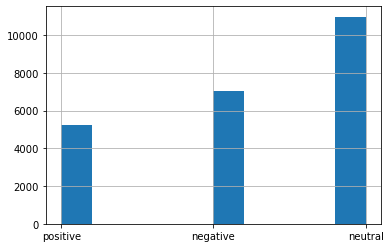

In [ ]:
train_1 = pd.read_excel('train_1.xlsx')[['PhraseText','label']]
train_1=train_1.drop_duplicates()
cnt_1 = train_1.groupby('PhraseText',as_index=False).count()
cnt_intent_1 = list(cnt_1[cnt_1.label!=1].PhraseText)
train_1 = train_1[~train_1.PhraseText.isin(cnt_intent_1)]


train_2 = pd.read_excel('train_2.xlsx')[['PhraseText','label']]
train_2=train_2.drop_duplicates()
cnt_2 = train_2.groupby('PhraseText',as_index=False).count()
cnt_intent_2 = list(cnt_2[cnt_2.label!=1].PhraseText)
train_2 = train_2[~train_2.PhraseText.isin(cnt_intent_2)]

train=train_1.merge(train_2, on='PhraseText', how='outer')

negatives=train[train.label_x==train.label_y][train.label_x=='negative'][['PhraseText','label_x']].rename(columns={"label_x": "label"})
neutrals=train[train.label_x==train.label_y][train.label_x=='neutral'][['PhraseText','label_x']].rename(columns={"label_x": "label"})
positives=train[train.label_x==train.label_y][train.label_x=='positive'][['PhraseText','label_x']].rename(columns={"label_x": "label"})
irony=train[train.label_x!=train.label_y][train.label_y=='negative'][['PhraseText','label_x']].rename(columns={"label_x": "label"})

pos = pd.read_excel('positives_no_smile.xlsx')
train=pd.concat([pos, positives, negatives, neutrals])

train.label.hist()

In [ ]:
train['PhraseText']=train['PhraseText'].apply(lambda x: clean(str(x)))

In [ ]:
train, test = train_test_split(train, test_size=0.1, random_state=42)

In [ ]:
list_for_drop=[]

for i in range(len(train)):
    text=train.PhraseText.iloc[i]
    if len(str(text))==0:
        list_for_drop.append(i)

train = train.drop(list_for_drop)

In [ ]:
list_for_drop=[]

for i in range(len(test)):
    text=test.PhraseText.iloc[i]
    if len(str(text))==0:
        list_for_drop.append(i)

test = test.drop(list_for_drop)

In [ ]:
train.to_excel("train_sent.xlsx")
test.to_excel("test_sent.xlsx")

In [ ]:
train['PhraseText']=train['PhraseText'].apply(lambda x: clean(str(x)))
train['label_pos']=train['label'].apply(lambda x: dig(x)[0])
train['label_neg']=train['label'].apply(lambda x: dig(x)[1])

reviews = train['PhraseText']
y_train_pos = train['label_pos']
y_train_neg = train['label_neg']

num_words = 10000
max_review_len = 100

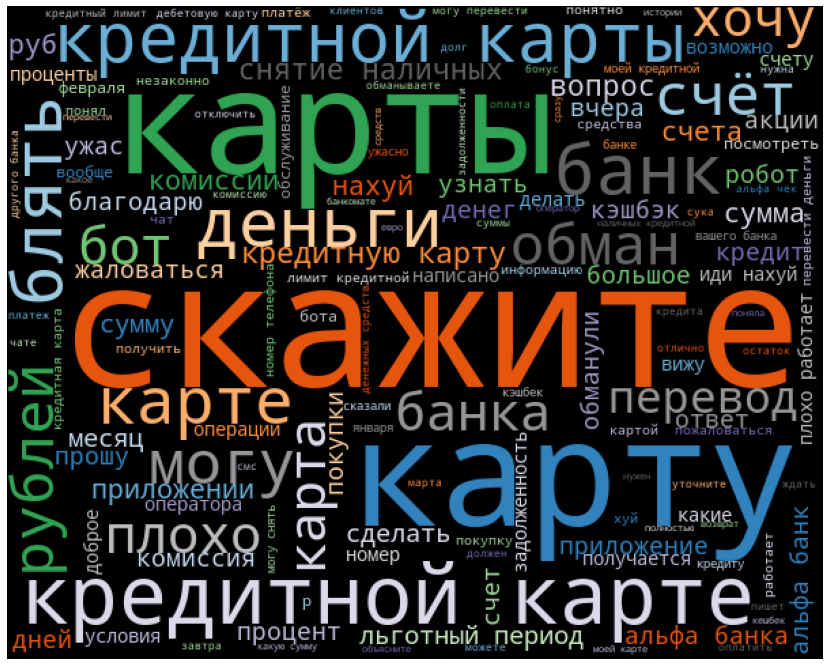

In [ ]:
text = ' '.join(train['PhraseText'].astype(str).str.lower().tolist())

wc = WordCloud().generate_from_text(text)

cloud = WordCloud(width=600,
                      height=480,
                      max_words=150,
                      colormap='tab20c',
                      stopwords=stop_words,
                      collocations=True).generate_from_text(text)
plt.figure(figsize=(15,12))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [ ]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
x_train = pad_sequences(sequences, maxlen=max_review_len)

model_rnn_pos = Sequential()
model_rnn_pos.add(Embedding(num_words, 2, input_length=max_review_len))
model_rnn_pos.add(SimpleRNN(8))
model_rnn_pos.add(Dense(1, activation='sigmoid'))

model_rnn_pos.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_rnn_pos = model_rnn_pos.fit(x_train,
                    y_train_pos,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.1)



Epoch 1/20
148/148 [==============================] - 3s 13ms/step - loss: 0.5486 - accuracy: 0.7675 - val_loss: 0.5243 - val_accuracy: 0.7735
Epoch 2/20
148/148 [==============================] - 2s 12ms/step - loss: 0.5077 - accuracy: 0.7723 - val_loss: 0.4808 - val_accuracy: 0.7783
Epoch 3/20
148/148 [==============================] - 2s 12ms/step - loss: 0.4469 - accuracy: 0.7975 - val_loss: 0.4410 - val_accuracy: 0.7979
Epoch 4/20
148/148 [==============================] - 2s 13ms/step - loss: 0.3793 - accuracy: 0.8314 - val_loss: 0.3467 - val_accuracy: 0.8528
Epoch 5/20
148/148 [==============================] - 2s 12ms/step - loss: 0.3246 - accuracy: 0.8718 - val_loss: 0.3040 - val_accuracy: 0.8872
Epoch 6/20
148/148 [==============================] - 2s 12ms/step - loss: 0.2866 - accuracy: 0.8924 - val_loss: 0.2899 - val_accuracy: 0.9044
Epoch 7/20
148/148 [==============================] - 2s 12ms/step - loss: 0.2601 - accuracy: 0.9050 - val_loss: 0.2606 - val_accuracy: 0.9044

In [ ]:
model_rnn_neg = Sequential()
model_rnn_neg.add(Embedding(num_words, 2, input_length=max_review_len))
model_rnn_neg.add(SimpleRNN(8))
model_rnn_neg.add(Dense(1, activation='sigmoid'))

model_rnn_neg.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_rnn_neg = model_rnn_neg.fit(x_train,
                    y_train_neg,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.1)

Epoch 1/20
148/148 [==============================] - 4s 16ms/step - loss: 0.5881 - accuracy: 0.6948 - val_loss: 0.5319 - val_accuracy: 0.6923
Epoch 2/20
148/148 [==============================] - 2s 13ms/step - loss: 0.4505 - accuracy: 0.7804 - val_loss: 0.3921 - val_accuracy: 0.8896
Epoch 3/20
148/148 [==============================] - 2s 14ms/step - loss: 0.3140 - accuracy: 0.9091 - val_loss: 0.2756 - val_accuracy: 0.9322
Epoch 4/20
148/148 [==============================] - 2s 15ms/step - loss: 0.2104 - accuracy: 0.9432 - val_loss: 0.1860 - val_accuracy: 0.9546
Epoch 5/20
148/148 [==============================] - 2s 13ms/step - loss: 0.1431 - accuracy: 0.9593 - val_loss: 0.1464 - val_accuracy: 0.9603
Epoch 6/20
148/148 [==============================] - 2s 13ms/step - loss: 0.1154 - accuracy: 0.9637 - val_loss: 0.1231 - val_accuracy: 0.9627
Epoch 7/20
148/148 [==============================] - 2s 14ms/step - loss: 0.0895 - accuracy: 0.9710 - val_loss: 0.1141 - val_accuracy: 0.9661

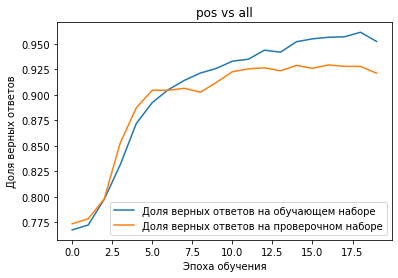

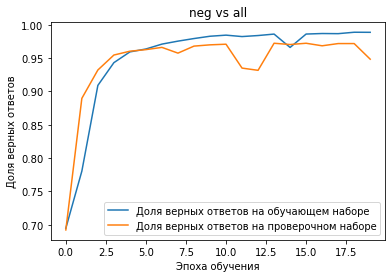

In [ ]:
plt.plot(history_rnn_pos.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_rnn_pos.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.title('pos vs all')
plt.show()


plt.plot(history_rnn_neg.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_rnn_neg.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.title('neg vs all')
plt.show()

In [ ]:
model_rnn_neg.fit(x_train,
                    y_train_neg,
                    epochs=5)

Epoch 1/5
654/654 [==============================] - 8s 12ms/step - loss: 0.0493 - accuracy: 0.9856
Epoch 2/5
654/654 [==============================] - 8s 12ms/step - loss: 0.0516 - accuracy: 0.9851
Epoch 3/5
654/654 [==============================] - 8s 12ms/step - loss: 0.0461 - accuracy: 0.9870
Epoch 4/5
654/654 [==============================] - 8s 12ms/step - loss: 0.0492 - accuracy: 0.9860
Epoch 5/5
654/654 [==============================] - 8s 12ms/step - loss: 0.0520 - accuracy: 0.9859


In [ ]:
model_rnn_pos.fit(x_train,
                    y_train_pos,
                    epochs=5)

Epoch 1/5
654/654 [==============================] - 7s 11ms/step - loss: 0.1171 - accuracy: 0.9576
Epoch 2/5
654/654 [==============================] - 7s 11ms/step - loss: 0.1147 - accuracy: 0.9589
Epoch 3/5
654/654 [==============================] - 7s 11ms/step - loss: 0.1142 - accuracy: 0.9585
Epoch 4/5
654/654 [==============================] - 7s 11ms/step - loss: 0.1099 - accuracy: 0.9598
Epoch 5/5
654/654 [==============================] - 7s 11ms/step - loss: 0.1112 - accuracy: 0.9596


In [ ]:
def sent_pred(text):
    text=clean(text)
    sequence = tokenizer.texts_to_sequences([text])
    data = pad_sequences(sequence, maxlen=max_review_len)
    result_neg = model_rnn_neg.predict(data)
    result_pos = model_rnn_pos.predict(data)
    return(result_neg,result_pos)

In [ ]:
with suppress_stdout():
    test['pred']=test.PhraseText.apply(lambda x: sent_pred(x))

In [ ]:
test['pred_neg']=test.pred.apply(lambda x: x[0][0][0])
test['pred_pos']=test.pred.apply(lambda x: x[1][0][0])

In [ ]:
def new_label(pred_neg,pred_pos,neg_treshold,pos_treshold):
    if (pred_neg<neg_treshold and pred_pos<pos_treshold):
        label='neutral'
    elif (pred_neg>=neg_treshold and pred_pos<pos_treshold):
        label='negative'
    elif (pred_neg<neg_treshold and pred_pos>=pos_treshold):
        label='positive'
    else:
        label='neutral'
    return(label)

In [ ]:
trsh=[0.6,0.7,0.8,0.9,0.95]
for pos_treshold in trsh:
    for neg_treshold in trsh:
        test['new_label']=0
        for i in range(len(test)):
            pred_neg=test['pred_neg'].iloc[i]
            pred_pos=test['pred_pos'].iloc[i]
            test['new_label'].iloc[i]=new_label(pred_neg,pred_pos,neg_treshold,pos_treshold)
        print(neg_treshold, pos_treshold)
        print('Accuracy score: %.3f' % accuracy_score(test.label, test.new_label))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.6 0.6
Accuracy score: 0.910


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.7 0.6
Accuracy score: 0.909


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.8 0.6
Accuracy score: 0.904


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.9 0.6
Accuracy score: 0.897


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.95 0.6
Accuracy score: 0.890


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.6 0.7
Accuracy score: 0.906


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.7 0.7
Accuracy score: 0.905


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.8 0.7
Accuracy score: 0.899


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.9 0.7
Accuracy score: 0.892


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.95 0.7
Accuracy score: 0.886


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.6 0.8
Accuracy score: 0.898


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.7 0.8
Accuracy score: 0.896


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.8 0.8
Accuracy score: 0.891


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.9 0.8
Accuracy score: 0.884


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.95 0.8
Accuracy score: 0.877


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.6 0.9
Accuracy score: 0.879


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.7 0.9
Accuracy score: 0.878


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.8 0.9
Accuracy score: 0.873


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.9 0.9
Accuracy score: 0.865


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.95 0.9
Accuracy score: 0.858


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.6 0.95
Accuracy score: 0.858


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.7 0.95
Accuracy score: 0.856


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.8 0.95
Accuracy score: 0.851


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.9 0.95
Accuracy score: 0.844


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0.95 0.95
Accuracy score: 0.837


In [ ]:
def sent(text):
    text=clean(text)
    sequence = tokenizer.texts_to_sequences([text])
    data = pad_sequences(sequence, maxlen=max_review_len)
    result_neg = model_rnn_neg.predict(data)
    result_pos = model_rnn_pos.predict(data)
    if result_neg>0.9:
        sent=-1
    elif result_pos>0.9:
        sent=1
    else:
        sent=0
    return(sent,result_neg,result_pos)

In [ ]:
text='как вы меня бесите'
sent(text)

1/1 [==============================] - 0s 24ms/step


(0, array([[0.5509859]], dtype=float32), array([[0.0910634]], dtype=float32))

In [ ]:
text = '''Здравствуйте, 00 июня с моей карты списались деньги без моего ведома XXXXX'''
sent(text)

1/1 [==============================] - 0s 20ms/step


(0, array([[0.00268278]], dtype=float32), array([[0.8016426]], dtype=float32))

In [ ]:
model_neg = model_rnn_neg
model_pos = model_rnn_pos


# Saving the model to a path on localhost.
saved_model_path = '/tmp/tf_save'
save_options = tensorflow.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_neg.save(saved_model_path, options=save_options)
model_pos.save(saved_model_path, options=save_options)

INFO:tensorflow:Assets written to: /tmp/tf_save\assets
INFO:tensorflow:Assets written to: /tmp/tf_save\assets


In [ ]:
saved_model_path = '/tmp/tf_save'
load_options = tensorflow.saved_model.LoadOptions(experimental_io_device='/job:localhost')
model_pos = tensorflow.keras.models.load_model(saved_model_path, options=load_options)

In [ ]:
import pyodbc

server = ''
database = ''
username = ''
password = ''
driver= 'SQL Server'

connection = pyodbc.connect('DRIVER='+driver+';SERVER='+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)

requestString_sessions = '''select max(Date) from [report].[message_status_sentiment] '''

max_date = pd.read_sql_query(requestString_sessions,connection)

max_date = str(max_date.iloc[0][0])[:-3]

print(max_date)

requestString_sessions = '''select min(Date) from [report].[message_status_sentiment]'''

min_date = pd.read_sql_query(requestString_sessions,connection)

min_date = str(min_date.iloc[0][0])[:-3]

print(min_date)

N
N


In [ ]:
cursor = connection.cursor()
for index, row in df.iterrows():
    cursor.execute("INSERT INTO [ChatBotData].[report].[message_status_sentiment] (Date,SessionID,MessageID,Sentiment) \
                   values(?,?,?,?)",
    row.TimeStart,row.SessionID,row.MessageID,row.sent)
connection.commit()
cursor.close()

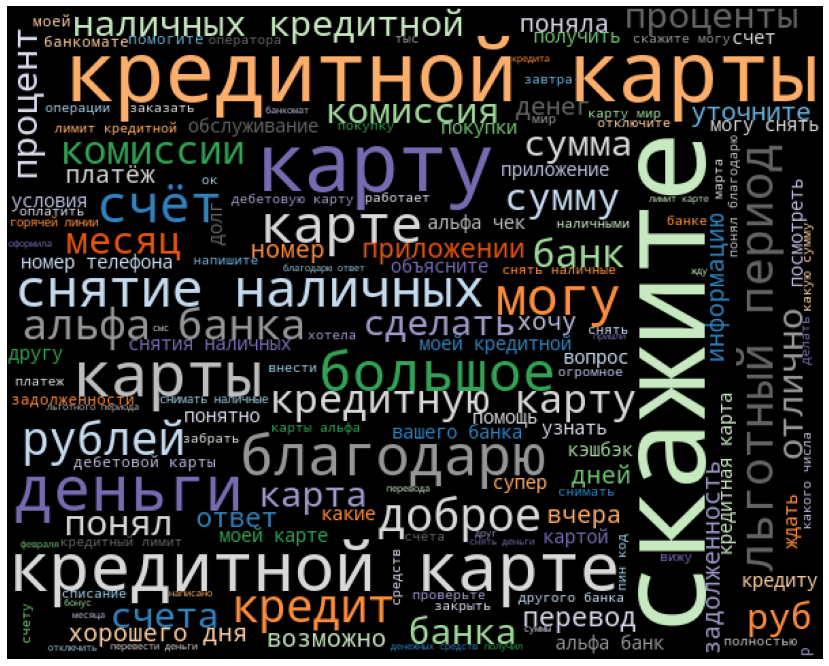

In [ ]:
text = ' '.join(train[train.label=='positive']['PhraseText'].astype(str).str.lower().tolist())

wc = WordCloud().generate_from_text(text)

cloud = WordCloud(width=600,
                      height=480,
                      max_words=150,
                      colormap='tab20c',
                      stopwords=stop_words,
                      collocations=True).generate_from_text(text)
plt.figure(figsize=(15,12))
plt.imshow(cloud)
plt.axis('off')
plt.show()

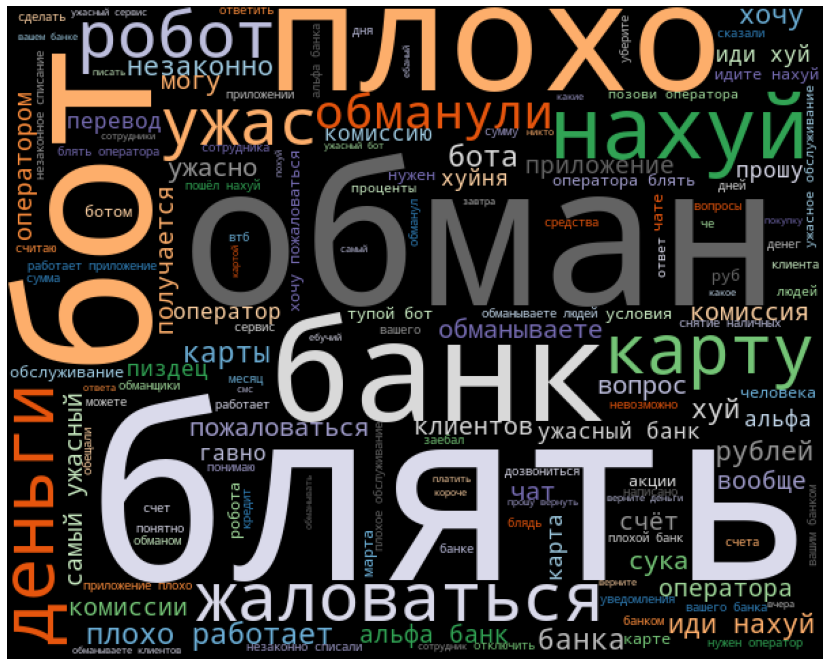

In [ ]:
text = ' '.join(train[train.label=='negative']['PhraseText'].astype(str).str.lower().tolist())

wc = WordCloud().generate_from_text(text)

cloud = WordCloud(width=600,
                      height=480,
                      max_words=150,
                      colormap='tab20c',
                      stopwords=stop_words,
                      collocations=True).generate_from_text(text)
plt.figure(figsize=(15,12))
plt.imshow(cloud)
plt.axis('off')
plt.show()